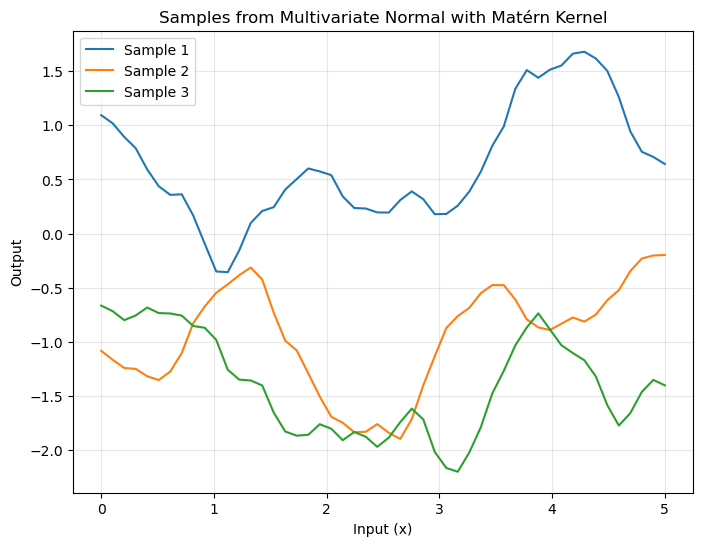

In [1]:
"""
Plot input vs. output for 3 samples using Matérn Kernel.
"""

import torch
import gpytorch
import matplotlib.pyplot as plt

# Define the Matérn kernel
class MaternKernel:
    def __init__(self, lengthscale=1.0, nu=1.5):
        self.lengthscale = lengthscale
        self.nu = nu

    def __call__(self, x1, x2):
        distance = torch.cdist(x1 / self.lengthscale, x2 / self.lengthscale, p=2)
        if self.nu == 0.5:  # Equivalent to exponential kernel
            return torch.exp(-distance)
        elif self.nu == 1.5:
            sqrt_3_dist = torch.sqrt(torch.tensor(3.0)) * distance
            return (1 + sqrt_3_dist) * torch.exp(-sqrt_3_dist)
        elif self.nu == 2.5:
            sqrt_5_dist = torch.sqrt(torch.tensor(5.0)) * distance
            return (1 + sqrt_5_dist + (5 / 3) * distance**2) * torch.exp(-sqrt_5_dist)
        else:
            raise NotImplementedError("Only nu = 0.5, 1.5, 2.5 are supported for simplicity.")

# Generate input points
x = torch.linspace(0, 5, 50).unsqueeze(1)

# Create a Matérn kernel instance
kernel = MaternKernel(lengthscale=1.0, nu=1.5)

# Compute covariance matrix
covariance_matrix = kernel(x, x)

# Define the mean vector
mean = torch.zeros(x.shape[0])

# Create the multivariate normal distribution
mvn = gpytorch.distributions.MultivariateNormal(mean, covariance_matrix)

# Sample data
samples = mvn.rsample(torch.Size([3]))  # Generate 3 sample paths

# Plot the sampled data
plt.figure(figsize=(8, 6))
for i in range(samples.shape[0]):
    plt.plot(x.numpy(), samples[i].numpy(), label=f"Sample {i + 1}")
plt.xlabel("Input (x)")
plt.ylabel("Output")
plt.title("Samples from Multivariate Normal with Matérn Kernel")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
covariance_matrix

tensor([[1.0000, 0.1070, 0.0926,  ..., 0.1392, 0.4529, 0.0698],
        [0.1070, 1.0000, 0.2841,  ..., 0.2530, 0.0581, 0.1990],
        [0.0926, 0.2841, 1.0000,  ..., 0.0465, 0.0262, 0.9077],
        ...,
        [0.1392, 0.2530, 0.0465,  ..., 1.0000, 0.2010, 0.0305],
        [0.4529, 0.0581, 0.0262,  ..., 0.2010, 1.0000, 0.0184],
        [0.0698, 0.1990, 0.9077,  ..., 0.0305, 0.0184, 1.0000]])

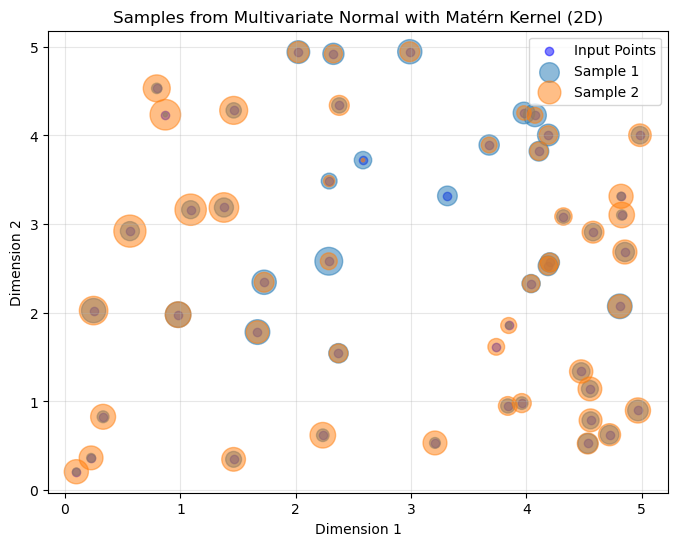

In [8]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Define the Matérn kernel
class MaternKernel:
    def __init__(self, lengthscale=1.0, nu=1.5):
        self.lengthscale = lengthscale
        self.nu = nu

    def __call__(self, x1, x2):
        # Normalize by lengthscale
        scaled_x1 = x1 / self.lengthscale
        scaled_x2 = x2 / self.lengthscale
        # Compute pairwise Euclidean distances
        distance = torch.cdist(scaled_x1, scaled_x2, p=2)
        if self.nu == 0.5:  # Exponential kernel
            return torch.exp(-distance)
        elif self.nu == 1.5:
            sqrt_3_dist = torch.sqrt(torch.tensor(3.0)) * distance
            return (1 + sqrt_3_dist) * torch.exp(-sqrt_3_dist)
        elif self.nu == 2.5:
            sqrt_5_dist = torch.sqrt(torch.tensor(5.0)) * distance
            return (1 + sqrt_5_dist + (5 / 3) * distance**2) * torch.exp(-sqrt_5_dist)
        else:
            raise NotImplementedError("Only nu = 0.5, 1.5, 2.5 are supported for simplicity.")

# Generate 2D input points
x = torch.rand(50, 2) * 5  # 50 points in 2D space

# Create a Matérn kernel instance
kernel = MaternKernel(lengthscale=1.0, nu=1.5)

# Compute covariance matrix
covariance_matrix = kernel(x, x)

# Define the mean vector
mean = torch.zeros(x.shape[0])

# Create the multivariate normal distribution
mvn = gpytorch.distributions.MultivariateNormal(mean, covariance_matrix)

# Sample data
samples = mvn.rsample(torch.Size([2]))  # Generate 2 sample sets

# Plot the sampled data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), label="Input Points", color="blue", alpha=0.5)
for i in range(samples.shape[0]):
    plt.scatter(
        x[:, 0].numpy(),
        x[:, 1].numpy(),
        s=(samples[i].numpy() - samples[i].numpy().min()) * 100,
        alpha=0.5,
        label=f"Sample {i + 1}",
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Samples from Multivariate Normal with Matérn Kernel (2D)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
samples[0].numpy().min()

-1.2514302

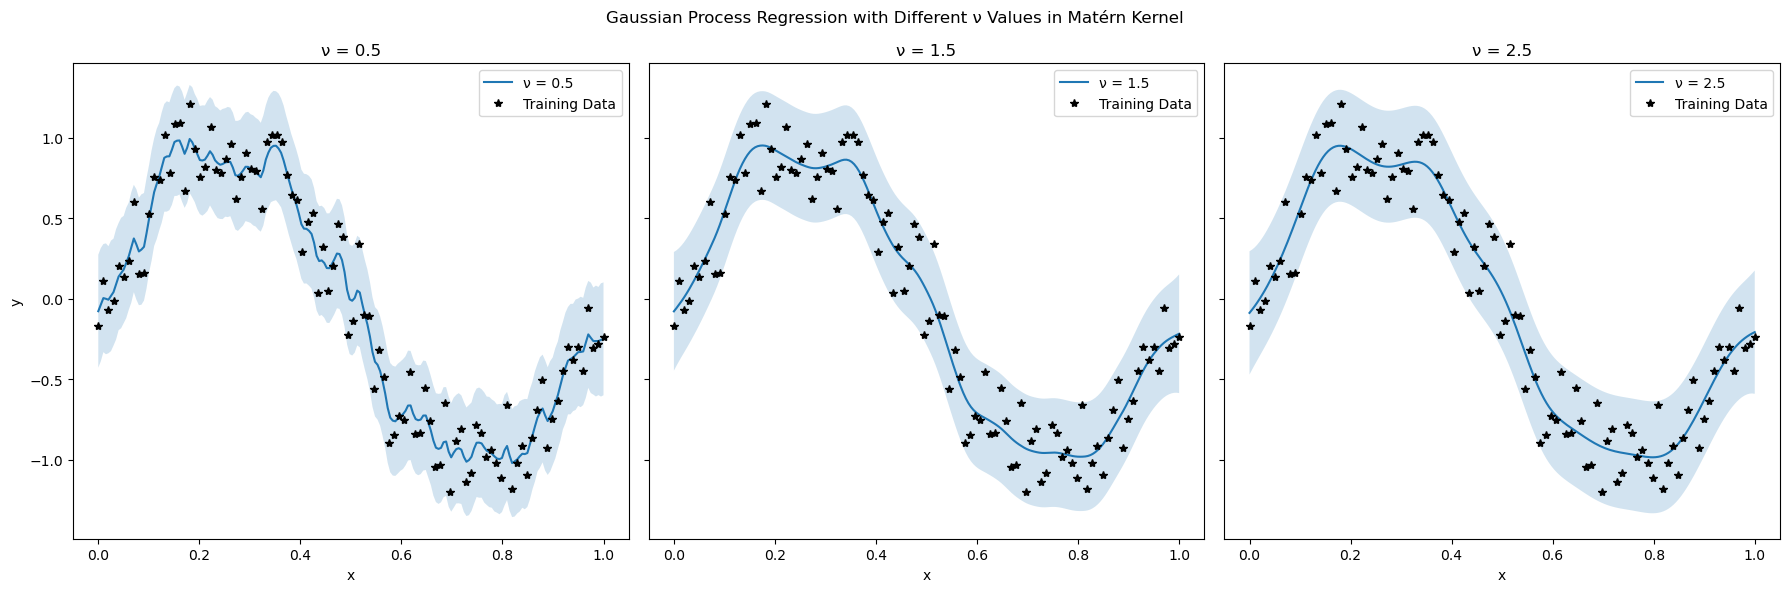

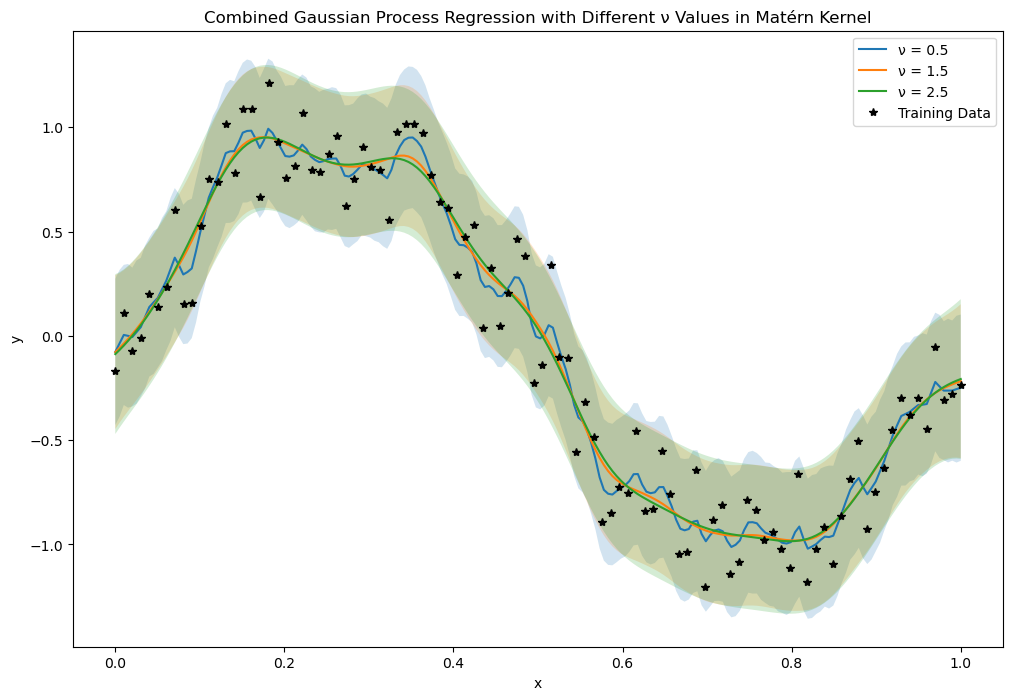

In [11]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Define training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2

# Define a simple GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=nu)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# List of nu values to compare
nu_values = [0.5, 1.5, 2.5]

# Prepare for separate plots in the same row
fig, axes = plt.subplots(1, len(nu_values), figsize=(18, 6), sharey=True)
combined_mean = []
combined_lower = []
combined_upper = []

for i, nu in enumerate(nu_values):
    # Define likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, nu=nu)

    # Train the model
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    training_iter = 50
    for _ in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    # Make predictions
    model.eval()
    likelihood.eval()
    test_x = torch.linspace(0, 1, 200)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))

    # Extract the predictive mean and confidence intervals
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

    combined_mean.append(mean)
    combined_lower.append(lower)
    combined_upper.append(upper)

    # Plot the predictive mean and confidence intervals
    axes[i].plot(test_x.numpy(), mean.numpy(), label=f'\u03BD = {nu}')
    axes[i].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2)
    axes[i].plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
    axes[i].set_title(f'\u03BD = {nu}')
    axes[i].set_xlabel('x')
    if i == 0:
        axes[i].set_ylabel('y')
    axes[i].legend()

plt.suptitle('Gaussian Process Regression with Different \u03BD Values in Mat\u00E9rn Kernel')
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(12, 8))
for i, nu in enumerate(nu_values):
    plt.plot(test_x.numpy(), combined_mean[i].numpy(), label=f'\u03BD = {nu}')
    plt.fill_between(test_x.numpy(), combined_lower[i].numpy(), combined_upper[i].numpy(), alpha=0.2)

plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.title('Combined Gaussian Process Regression with Different \u03BD Values in Mat\u00E9rn Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
